# Actividad PBL 2. Redes Bayesianas

### **Integrantes**
* Salette Noemi Villalobos
* Samuel Méndez Villegas
* Paola Vega Ortega
* Ethan Verduzco Pérez
* Santiago

### **Docente**
* Dr. Daniel Otero Fadul


## **Objetivos trazados**



*   El objetivo principal de la actividad es desarrollar las habilidades y los conocimientos para diseñar una red bayesiana. Entender sus fundamentos y sus limitaciones. Además, manejar distintos tipos de representación gráfica de datos y herramientas de visualización, utilizando frecuentemente dichas técnicas de manera combinada, a través del uso del lenguaje computacional de Python.

*   De igual manera, el propósito secundario de esta actividad es desarrollar bajo la metodología de SCRUM y PBL, una serie de pasos que nos permitan reforzar las competencias de organización, comunicación y colaboración y que a su vez facilite el construir el conocimiento necesario para resolver el problema.
 

## **Enfoque**



Para poder identificar Muertes por diagnósticos médicos erróneos y diseñar un modelo de causa-efecto que permita prevenir malos diagnósticos, se aplicarán conceptos de Redes Bayesianas y algoritmos de inferencia con Redes Bayesianas. Dicho modelo se explicará cómo funciona más adelante, ya que antes, se dará a conocer el punto de partida y los pasos a seguir para construir el clasificador.

Nuestro punto de partida, es una base de datos que contiene la información de 2000 registros de pacientes, en los que obtenemos la manera en la que fueron catalogados ya sea '0' o '1' dependiendo si su resultado a la prueba de diabetes fue negativa o positiva y una serie de registros con otros tipo de atributos que fueron necesarios y útiles para llegar a cabo a dicha conclusión como lo son su edad, peso, BMI, entre muchos otros. Cabe mencionar que la base de datos con la que se estará trabajando, fue obtenida de *Kaggle* y se puede descargar a través del siguiente enlace: `  https://www.kaggle.com/vikasukani/diabetes-data-set         `.
 
Dicho lo anterior, ahora se pasará a describir la serie de pasos que se seguirá para construir el clasificador de spam.

1.  **Importar las librerías**

Se utilizará itertools como herramienta de iterador y permutaciones y combinaciones, networkx y matplotlib para la visualización, pandas para cargar datos, NumPy para acceder a los valores de los cuartiles y Bbn para llevar a cabo la creación de la Red Bayesiana.

2.   **Carga de Datos**

Importamos el data set como Data Frame a Python e iniciamos la lectura de datos. 

3.  **Procesamiento de la base de datos**

Para poder llevar adecuadamente el modelo es necesario preparar y procesar adecuadamente los datos y la información que encontramos dentro de nuestra base de datos acerca de los registros de los pacientes almacenados para que el proceso de razonamiento y aplicación del modelo sea más sencillo y eficiente de llevar a cabo. Dentro de algunos de los pasos que se llevarán a cabo se encuentran:

*   Agregar columna 'overweight' a la base de datos:

En función del valor registrado del BMI del paciente, Indice de Masa Corporal (IMC) en español, el cual mide el contenido de grasa corporal en relación a la estatura y el peso que presentan tanto los hombres como las mujeres se definirá el valor para la nueva categoría por añadir, para definir si el paciente tiene sobrepeso o no. El nombre de la columna se mantiene en inglés para mantener coherencia con el resto de los atributos de la base de datos. 

*   Discretizar variables continuas:

A través de una función de python y utilizando como parámetro toda la base de datos, se obtendrán los cuartiles de los datos, para formar múltiples rangos que nos permitan categorizar la información dependiendo del sector que pertenezcan. Después, se lleva a cabo la discretización para las variables continuas. 


*   Filtrado y preprocesamiento de los datos


4.   **Calcular las tablas de probabilidades para cada uno de los nodos**

Inicialmente crearemos un diccionarios que tendrá como llaves los nombres de todos los atributos de nuestra base de datos, que modelará la red bayesiana. Seguido de esto, se hará uso de otra función que calcule las probabilidades de cada nodo, en el que visitará cada llave del diccionario para ir añadiendo dichas probabilidades según los resultados obtenidos, dependiendo si los nodos no tienen ningún padre, tienen un solo padre, tienen dos padres, o si tienen más de dos padres como lo es el caso de la variable 'Outcome'. Finalmente, imprimos los resultados de las probabilidades añadidas al diccionario para verificar que el procedimiento se llevó a cabo de manera adecuada. 

5.  **Creación de la red Bayesiana**

Para implementar nuestra red Bayesiana, es necesario acceder previamente a la lista de probabilidades de cada nodo y almacenar los valores dentro de una nueva variable que identifique las probabilidades de cada atributo. Seguido de esto ya es posible llevar a cabo la creación de la red, en donde declararemos nuestras variables, los valores que puede contener la variable, según cada atributos con el que contamos, y sus respectivas probabilidades. 

6. **Visualización de la red Bayesiana**

El siguiente paso estará enfocado en establecer los nodos y las conexiones entre éstos, inicializando un Bbn, en el que se le irán añadiendo nodos, según nuestras variables otorgadas en la base datos. Finalmente, una vez que haya sido configurada exitosamente la red, se convertirá el Bbn en un sólo árbol unido. Más en concreto para la visualización final, finalmente se tiene que configurar las posiciones de los nodos, las opciones de cómo queremos que se vea el gráfico como el tipo de fuente, tamaño de letra, tamaño y color de los nodos, entre muchas otras, para poder llevar a cabo el plot del resultado correctamente. 

7. **Probando la red bayesiana para calcular la probabilidad de 'Diabetes'**

## **Información**

### Redes Bayesianas

Las redes bayesianas representan por medio de un grafo las dependencias para realizar un razonamiento probabilístico. Los nodos son las variables del sistema mientras que los arcos muestran las relaciones de dependencia directa entre dichas variables. Es decir, en esta técnica se emplea la dependencia entre variables para modelar fenómenos y hacer inferencia bayesiana. Algunas de las aplicaciones de estos modelos son para clasificar, predecir, diagnosticar, etc. 


La red bayesiana más simple no trivial que se puede encontrar es aquella compuesta por dos variables y un arco dirigido, como la que se presenta a continuación:


<img src="Red Bayesiana (1).png">

La variable Y (hija), que se encuentra en la punta del arco, es dependiente de la cual se origina el arco, la variable X (padre). 


La información de una red bayesiana se constituye por:

*  La probabilidad a priori de los nodos sin padres.
*  La probabilidad condicional de los demás nodos.

En las redes bayesianas simples, se asume la independencia condicional entre variables que no estén directamente conectadas, esto garantiza a su vez la independencia de la distribución de probabilidad, con el fin de la simplificación de los parámetros y la propagación de las probabilidades. La independencia en una red bayesiana, donde X es independiente de Y dado Z, se puede representar como:

$$ P(X|Y,Z) = P(X|Z) $$

<img src="Red Bayesiana.png">

### Separación D
Para una explicación más detallada de esta condición, primero se deben especificar las definiciones de los nodos donde:

*  Nodos en secuencia: 

$$A -> B -> C$$

*  Nodos divergentes: 

$$A <- B -> C$$
*  Nodos convergentes:

$$A -> B <- C$$


De acuerdo con el criterio de la Separación D:


“El conjunto de variables A es independiente del conjunto de variables B dado el conjunto C si no existe trayectoria entre A y B en que:

1.	Todos los nodos convergentes están o tienen descendientes en C.
2.	Todos los demás nodos están fuera de C.”

En pocas palabras, la única forma de que una variable sea dependiente de la otra es si es su descendiente directa.


### Cobija de Markov
La cobija de Markov se refiere al conjunto de nodos que vuelven a un nodo independiente del resto, está formada por:

*  Nodo padre
*  Nodo hijo
*  Otros padres de los hijos


### Probabilidad conjunta
Gracias a que los padres especifican la estructura, se pueden utilizar las probabilidades condicionales para llegar a la probabilidad buscada. Si se aplica la regla de la cadena y la independencia de las variables, es posible calcular la probabilidad conjunta. De forma generalizada, la fórmula se vería como la siguiente:

$$
P(X_1,X_2, ...,X_n) = \prod_{i=1}^{n}P(X_i|Pa(X_i))
$$



Donde la probabilidad conjunta es el producto de las probabilidades condicionales de cada variable y sus padres. El tamaño de la tabla de probabilidades condicionales está sujeta al número de padres que tenga el respectivo nodo, crece exponencialmente por lo que puede llegar a ser muy grande. Los modelos canónicos son una solución a este problema, se utilizan para representar las tablas sin necesidad de detallar todas las probabilidades, sin embargo, durante el desarrollo de este ejercicio, no se utilizarán modelos canónicos. 




### Modelado con redes bayesianas

Generalmente los modelos que utilizan redes bayesianas, son aquellos de diagnóstico o predicción. Para hacerlo se llevan a cabo los siguientes pasos:

1. Identificación de las variables

En la mayoría de los casos, se necesitan expertos en el área para tener un grado máximo de compresión sobre el problema que se está modelando. Con los conocimientos máximos del tema, se procede a encontrar aquellas variables de interés para el problema. 

*  Variables objetivo

Útiles para modelar los objetos de interés, aquellos sobre los que no interesa sacar conclusiones. Usualmente funcionan para fenómenos latentes, un ejemplo de su uso es en los diagnósticos médicos. 

*  Variables de observación

También llamadas variables de evidencia, se utilizan para modelar las formas indirectas en las que es posible medir las variables objetivo. Por ejemplo, los síntomas o resultados de pruebas de un paciente pueden ser las observaciones de un diagnóstico médico. Existen variables de observación obligatorias, o sea indispensables para obtener la conclusión.

*  Factores

También llamadas variables de contexto. Modelan fenómenos que afectan a las variables objetivo. Pueden ser promotores, inhibidores, requeridos, preventivos y auxiliares.

2. Estados y valores

Las variables también pueden ser definidas por su escala de medición:

* Variables cualitativas

Expresan cualidades, características o modalidad. La medición consiste en clasificar cada atributo del sujeto. Pueden ser dicotómicas, es decir que únicamente puede tomar dos valores, o politómicas, pueden adquirir más de dos valores. Este es el caso de las variables del ejercicio.

* Variables cuantitativas

Se expresan mediante cantidades numéricas. Pueden ser tanto discretas como continuas. 

3. Estructura

Después de la definición de variables, es necesario definir la estructura del modelo, para ello se conectan las variables directamente relacionadas con arcos dirigidos. La presencia de un arco representa una influencia causal entre dos variables y siempre se construye en dirección de la causa.

4. Parámetros

El último paso consiste en el cálculo de los parámetros, estos son las probabilidades a priori de los nodos sin padre y las probabilidades condicionales del resto. Las alternativas para obtener los parámetros son: 

* Especificación de los parámetros por parte de expertos. 
* Aprendizaje a partir de las bases de datos. A partir de este se tienen dos opciones: 

    * Aprendizaje de los parámetros: en caso de que ya se disponga de la estructura
    
    * Aprendizaje estructural: se aprenden la estructura y los parámetros.

* Combinar especificación y aprendizaje. 


### Aprendizaje paramétrico

Con datos completos y suficientes, con la estructura dada, es posible obtener los parámetros. Usualmente se utiliza el *estimador de máxima verosimilitud*, por el cual se estiman las probabilidades basándose en las frecuencias de los datos. Se tienen dos casos:

* Nodos raíz. Únicamente se calcula la probabilidad marginal.

$$ P(A_i) = \frac{N_{A_i}}{N}$$

* Nodos hojas. Se estima la probabilidad condicional utilizando la probabilidad de los padres. 

$$ P(B_i|A_j,C_k) = \frac{N_{B_i,A_j,C_k}}{N_{A_j,C_k}}$$

Este es el modelo que se aplicó en el ejercicio. Normalmente no se tiene suficientes datos y se utiliza una distribución de probabilidad.

#### Discretización de variables continuas

Normalmente en las redes bayesianas se consideran variables discretas o nominales, existen modelos que utilizan variables continuas, pero están limitados a variables gaussianas y relaciones lineales. Los métodos de discretización pueden ser: 

* No supervisados

Los atributos son discretizados independientemente. Es el método que se utilizó en la resolución del ejercicio. 

* Supervisados

Consideran la variable clase. Generalmente es costoso y se recurre a un método heurístico. 




## **Razonamiento**

## **1. Importar librerías**

In [2]:
import pandas as pd### **1. Importar librerías**
import numpy as np ## Se utilizará para acceder a los valores de los cuartiles
import itertools ## Se utiliza para las combinaciones posibles 

## **2. Carga de Datos**

In [4]:
## Carga de la base de datos
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


## **3. Procesamiento de la base de datos**

### **3.1 Agregar columna 'overweight' a la base de datos**

In [3]:
overweight = []

for i in diabetes['BMI']:
    if i >= 25:
        overweight.append(1) # personas con sobrepeso
    else:
        overweight.append(0) # personas sin sobrepeso

diabetes['Overweight'] = overweight
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,138,62,35,0,33.6,0.127,47,1,1
1,0,84,82,31,125,38.2,0.233,23,0,1
2,0,145,0,0,0,44.2,0.630,31,1,1
3,0,135,68,42,250,42.3,0.365,24,1,1
4,1,139,62,41,480,40.7,0.536,21,0,1
5,0,173,78,32,265,46.5,1.159,58,0,1
6,4,99,72,17,0,25.6,0.294,28,0,1
7,8,194,80,0,0,26.1,0.551,67,0,1
8,2,83,65,28,66,36.8,0.629,24,0,1
9,2,89,90,30,0,33.5,0.292,42,0,1


### **3.2 Discretizar variables continuas**

In [4]:
## Se calculan los rangos con ayuda de los cuartiles y se discretizan las variables continuas.

def discretize(df):
    
    df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'] * 100 ## Se multiplica por 100 para realizar correctamente la aginación de rango
    
    for i in df:
    
        if (i == 'Outcome') | (i == 'Overweight'): ## Estas columnas ya son discretas
            continue
            
        else: 
                
            ## Se obtienen los cuartiles para formar los rangos

            q1 = np.percentile(df[i][df[i] > 0], 25)
            q2 = np.percentile(df[i][df[i] > 0], 50)
            q3 = np.percentile(df[i][df[i] > 0], 75)

            print('Variable:', i)
            print('Cuartil 1:', q1)
            print('Cuartil 2:', q2)
            print('Cuartil 3:', q3)

            ## Se realiza la discretización

            df[i] = df[i].replace(df[i][df[i] < q1], 1)
            df[i] = df[i].replace(df[i][(df[i] >= q1) & (df[i] < q2)], 2)
            df[i] = df[i].replace(df[i][(df[i] >= q2) & (df[i] < q3)], 3)
            df[i] = df[i].replace(df[i][df[i] >= q3], 4)
            
    return df

In [5]:
df = discretize(diabetes) 
df

Variable: Pregnancies
Cuartil 1: 2.0
Cuartil 2: 4.0
Cuartil 3: 6.0
Variable: Glucose
Cuartil 1: 99.0
Cuartil 2: 117.0
Cuartil 3: 141.0
Variable: BloodPressure
Cuartil 1: 64.0
Cuartil 2: 72.0
Cuartil 3: 80.0
Variable: SkinThickness
Cuartil 1: 22.0
Cuartil 2: 29.0
Cuartil 3: 36.0
Variable: Insulin
Cuartil 1: 76.75
Cuartil 2: 126.0
Cuartil 3: 190.0
Variable: BMI
Cuartil 1: 27.5
Cuartil 2: 32.4
Cuartil 3: 36.8
Variable: DiabetesPedigreeFunction
Cuartil 1: 24.4
Cuartil 2: 37.6
Cuartil 3: 62.4
Variable: Age
Cuartil 1: 24.0
Cuartil 2: 29.0
Cuartil 3: 40.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,3,1,3,1,3.0,1.0,4,1,1
1,1,1,4,3,2,4.0,1.0,1,0,1
2,1,4,1,1,1,4.0,4.0,3,1,1
3,1,3,2,4,4,4.0,2.0,2,1,1
4,1,3,1,4,4,4.0,3.0,1,0,1
5,1,4,3,3,4,4.0,4.0,4,0,1
6,3,2,3,1,1,1.0,2.0,2,0,1
7,4,4,4,1,1,1.0,3.0,4,0,1
8,2,1,2,2,1,4.0,4.0,2,0,1
9,2,1,4,3,1,3.0,2.0,4,0,1


## **4. Calcular las tablas de probabilidades para cada uno de los nodos**

In [6]:
## Función auxiliar para eliminar los nombres de los padres

def pop_elements(a):
    for i in range(len(a)):
        a.pop()

In [7]:
## Diccionario que modela la red Bayesiana

dib_dict = {'Pregnancies' : [], 
            'Age' : [], 
            'DiabetesPedigreeFunction' : [], 
            'Overweight' : [], 
            'Insulin' : ['Outcome'], 
            'SkinThickness' : ['Overweight'], 
            'BMI' : ['Overweight'],
            'Glucose' : ['Outcome'],
            'BloodPressure' : ['Outcome', 'Overweight'], 
            'Outcome' : ['Pregnancies', 'Age', 'DiabetesPedigreeFunction', 'Overweight']}

In [8]:
## Función que calcula las probabilidades de cada nodo.

def probability_tables(df, dictionary):
    
    total = len(df)
    
    for key in dictionary:
        
        if len(dictionary[key]) == 0:  ## Se refiere a los nodos que no tienen padres
            
            for i in sorted(df[key].unique()):
                prob = df[df[key] == i].shape[0] / total
                dictionary[key].append(prob)
                
        
        elif len(dictionary[key]) == 1: ## Se refiere a los nodos con un solo padre (todos tienen 8 combinaciones)
            
            father = dictionary[key][0]
            pop_elements(dictionary[key])
            
            counter = 1
            
            for i in range(1, 9, 1): ## Se repite 8 veces porque son 8 combinaciones posibles
                
                if counter > 4:
                    counter = 1
                
                if i < 5:
                    
                    prob = df[(df[key] == counter) & (df[father] == 0)].shape[0] / df[df[father] == 0].shape[0]
                    dictionary[key].append(prob)
                    counter += 1
                    
                else:

                    prob = df[(df[key] == counter) & (df[father] == 1)].shape[0] / df[df[father] == 1].shape[0]
                    dictionary[key].append(prob)
                    counter += 1
        
        elif len(dictionary[key]) == 2: ## Se refiere a los nodos con dos padres
            
            father1 = dictionary[key][0]
            father2 = dictionary[key][1]
                        
            pop_elements(dictionary[key]) 
        
            counter = 1
            
            for i in range(1, 17, 1): ## Se repite 16 veces porque son 16 combinaciones posibles
                
                if counter > 4:
                    counter = 1
                
                if i < 5:
                    prob = (df[(df[key] == counter) & (df[father1] == 0) & (df[father2] == 0)].shape[0] 
                            / df[(df[father1] == 0) & (df[father2] == 0)].shape[0])
                    
                    dictionary[key].append(prob)
                    counter += 1
                
                elif (i >= 5) & (i < 9):
                    prob = (df[(df[key] == counter) & (df[father1] == 0) & (df[father2] == 1)].shape[0] 
                            / df[(df[father1] == 0) & (df[father2] == 1)].shape[0])
                    
                    dictionary[key].append(prob)
                    counter += 1
                
                elif (i >= 9) & (i < 13):
                    prob = (df[(df[key] == counter) & (df[father1] == 1) & (df[father2] == 0)].shape[0] 
                            / df[(df[father1] == 1) & (df[father2] == 0)].shape[0])
                    
                    dictionary[key].append(prob)
                    counter += 1
                
                else:
                    prob = (df[(df[key] == counter) & (df[father1] == 1) & (df[father2] == 1)].shape[0] 
                            / df[(df[father1] == 1) & (df[father2] == 1)].shape[0])
                    
                    dictionary[key].append(prob)
                    counter += 1
                    
        else: ## Entra en nodos con más de 2 padres, es decir 'Outcome'
            
            father1 = dictionary[key][0]
            father2 = dictionary[key][1]
            father3 = dictionary[key][2]
            father4 = dictionary[key][3]
            
            pop_elements(dictionary[key])
            
            a = [[1,2,3,4],[1,2,3,4],[1,2,3,4], [0,1]] ## Lista de listas con los posibles valores de cada padre
            combinations = list(itertools.product(*a)) ## Lista de listas con todas las combinaciones posibles
            
            for i in combinations:
                
                v1 = i[0] 
                v2 = i[1]
                v3 = i[2]
                v4 = i[3]
                
                numerator1 = df[(df[key] == 0) & (df[father1] == v1) & (df[father2] == v2) & (df[father3] == v3) & (df[father4] == v4)].shape[0]
                numerator2 = df[(df[key] == 1) & (df[father1] == v1) & (df[father2] == v2) & (df[father3] == v3) & (df[father4] == v4)].shape[0]
                denominator = df[(df[father1] == v1) & (df[father2] == v2) & (df[father3] == v3) & (df[father4] == v4)].shape[0]
                
                if denominator == 0: ## Se evalúa si el denominador es eso
                    dictionary[key].append(1/2)
                    dictionary[key].append(1/2)
                    
                else:           
                    prob1 = numerator1 / denominator
                    dictionary[key].append(prob1)
                
                    prob2 = numerator2 / denominator
                    dictionary[key].append(prob2)
    
    return dictionary

In [9]:
## Diccionario resultante con las listas de probabilidades 

print(probability_tables(df, dib_dict))

{'Pregnancies': [0.3285, 0.2395, 0.166, 0.266], 'Age': [0.2305, 0.2595, 0.247, 0.263], 'DiabetesPedigreeFunction': [0.2485, 0.251, 0.2495, 0.251], 'Overweight': [0.1465, 0.8535], 'Insulin': [0.6451367781155015, 0.15121580547112462, 0.09954407294832827, 0.10410334346504559, 0.5380116959064327, 0.08771929824561403, 0.18567251461988304, 0.18859649122807018], 'SkinThickness': [0.8600682593856656, 0.10580204778156997, 0.027303754266211604, 0.006825938566552901, 0.39015817223198596, 0.1769185705916813, 0.2032806092560047, 0.22964264792032807], 'BMI': [1.0, 0.0, 0.0, 0.0, 0.12888107791446984, 0.28939660222612773, 0.28763913298183946, 0.29408318687756296], 'Glucose': [0.3252279635258359, 0.303951367781155, 0.2439209726443769, 0.12689969604863222, 0.06286549707602339, 0.16228070175438597, 0.27631578947368424, 0.49853801169590645], 'BloodPressure': [0.4411764705882353, 0.24632352941176472, 0.1801470588235294, 0.1323529411764706, 0.25, 0.23946360153256704, 0.26436781609195403, 0.24616858237547892

## **5. Creación de la red Bayesiana**

In [10]:
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn ## Recurden instalarla desde la termanl "pip install pybbn"

from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

![](diabetes.png)

In [11]:
## Se accede a la lista de probabilidades de cada nodo

pregnant_prob = dib_dict['Pregnancies']
age_prob = dib_dict['Age']
insulin_prob = dib_dict['Insulin']
diabetes_prob = dib_dict['Outcome']
dfp_prob = dib_dict['DiabetesPedigreeFunction']
overweight_prob = dib_dict['Overweight']
skin_prob = dib_dict['SkinThickness']
bmi_prob = dib_dict['BMI']
bp_prob = dib_dict['BloodPressure']
glucose_prob = dib_dict['Glucose']

## Se crea la red Bayesiana
pregnant = BbnNode(Variable(0, 'Pregnant', ['1', '2', '3', '4']), pregnant_prob)
age = BbnNode(Variable(1, 'Age', ['1', '2', '3', '4']), age_prob)
diabetes = BbnNode(Variable(2, 'Diabetes', ['0', '1']), diabetes_prob)
insulin = BbnNode(Variable(3, 'Insulin', ['1', '2', '3', '4']), insulin_prob)
dfp = BbnNode(Variable(4, 'DFP', ['1', '2', '3', '4']), dfp_prob)
bp = BbnNode(Variable(5, 'BP', ['1', '2', '3', '4']), bp_prob)
bmi = BbnNode(Variable(6, 'BMI', ['1', '2', '3', '4']), bmi_prob)
overweight = BbnNode(Variable(7, 'Overweight', ['0', '1']), overweight_prob)
skin = BbnNode(Variable(8, 'Skin', ['1', '2', '3', '4']), skin_prob)
glucose = BbnNode(Variable(9, 'Glucose', ['1', '2', '3', '4']), glucose_prob)

## **6. Visualización de la red Bayesiana**

In [12]:
## Se establecen los nodos y las conexiones entre éstos

bbn = Bbn() \
    .add_node(pregnant) \
    .add_node(age) \
    .add_node(diabetes) \
    .add_node(insulin) \
    .add_node(dfp) \
    .add_node(bp) \
    .add_node(bmi) \
    .add_node(overweight) \
    .add_node(skin) \
    .add_node(glucose) \
    .add_edge(Edge(pregnant, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(dfp, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, insulin, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, bp, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bp, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, skin, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, glucose, EdgeType.DIRECTED))\

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

/Users/Samuel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Samuel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


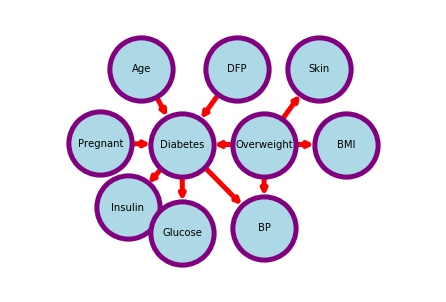

In [13]:
# Set node positions
pos = {0: (-6, 0.5), 1: (-3, 30), 2: (0, 0), 3: (-4, -25), 
       4: (4, 30), 5: (6, -33), 6: (12, 0), 7: (6, 0), 8: (10, 30), 9: (0, -35)}

# Set options for graph looks
options = {"font_size" : 10, "node_size" : 4000, "node_color" : "lightblue", 
           "edgecolors" : "purple", "edge_color" : "red", "linewidths" : 5, 
           "width": 5}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

## **7. Probando la red bayesiana para calcular la probabilidad de 'Diabetes'**

In [14]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
    
# Use the above function to print marginal probabilities
print_probs()

Node: 2|Diabetes|0,1
Values:
2=0|0.64305
2=1|0.35695
----------------
Node: 3|Insulin|1,2,3,4
Values:
3=1|0.60690
3=2|0.12855
3=3|0.13029
3=4|0.13426
----------------
Node: 7|Overweight|0,1
Values:
7=0|0.14650
7=1|0.85350
----------------
Node: 6|BMI|1,2,3,4
Values:
6=1|0.25650
6=2|0.24700
6=3|0.24550
6=4|0.25100
----------------
Node: 8|Skin|1,2,3,4
Values:
8=1|0.45900
8=2|0.16650
8=3|0.17750
8=4|0.19700
----------------
Node: 9|Glucose|1,2,3,4
Values:
9=1|0.23158
9=2|0.25338
9=3|0.25548
9=4|0.25956
----------------
Node: 5|BP|1,2,3,4
Values:
5=1|0.24924
5=2|0.23125
5=3|0.25840
5=4|0.26110
----------------
Node: 1|Age|1,2,3,4
Values:
1=1|0.23050
1=2|0.25950
1=3|0.24700
1=4|0.26300
----------------
Node: 4|DFP|1,2,3,4
Values:
4=1|0.24850
4=2|0.25100
4=3|0.24950
4=4|0.25100
----------------
Node: 0|Pregnant|1,2,3,4
Values:
0=1|0.32850
0=2|0.23950
0=3|0.16600
0=4|0.26600
----------------


In [15]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [22]:
# Use above function to add evidence
evidence('ev1', 'Pregnant', '1', 1)
evidence('ev2', 'BMI', '3', 1)
evidence('ev3', 'Overweight', '1', 1)
evidence('ev4', 'BP', '3', 1)
evidence('ev5', 'Glucose', '2', 1)
evidence('ev6', 'Skin', '4', 1)

# Print marginal probabilities
print_probs()

Node: 2|Diabetes|0,1
Values:
2=0|0.76539
2=1|0.23461
----------------
Node: 3|Insulin|1,2,3,4
Values:
3=1|0.62000
3=2|0.13632
3=3|0.11975
3=4|0.12393
----------------
Node: 7|Overweight|0,1
Values:
7=0|0.00000
7=1|1.00000
----------------
Node: 6|BMI|1,2,3,4
Values:
6=1|0.00000
6=2|0.00000
6=3|1.00000
6=4|0.00000
----------------
Node: 8|Skin|1,2,3,4
Values:
8=1|0.00000
8=2|0.00000
8=3|0.00000
8=4|1.00000
----------------
Node: 9|Glucose|1,2,3,4
Values:
9=1|0.00000
9=2|1.00000
9=3|0.00000
9=4|0.00000
----------------
Node: 5|BP|1,2,3,4
Values:
5=1|0.00000
5=2|0.00000
5=3|1.00000
5=4|0.00000
----------------
Node: 1|Age|1,2,3,4
Values:
1=1|0.26145
1=2|0.26579
1=3|0.23731
1=4|0.23545
----------------
Node: 4|DFP|1,2,3,4
Values:
4=1|0.26047
4=2|0.22803
4=3|0.26718
4=4|0.24432
----------------
Node: 0|Pregnant|1,2,3,4
Values:
0=1|1.00000
0=2|0.00000
0=3|0.00000
0=4|0.00000
----------------


In [21]:
join_tree = InferenceController.apply(bbn)